# **Numerical checks for the WongSolver**
In this notebook, we are going to perform various checks on our numerical routine for solving Wong's equations with Glasma background fields. 

## Comparison with `kappa.py` and `qhat.py` modules
In limiting cases, the momentum broadening of a parton may be extracted solely from Glasma fields. These cases are: an inifinitelly massive heavy quark, solved in `kappa.py` and an infinitely energetic jet moving along a certain direction, implemented in `qhat.py`. By choosing $m\rightarrow\infty$ in `wong.py`, we should the same momentum broadenings as from `kappa.py`, whereas initializing a parton with $p^x\rightarrow\infty$ should yield the same results as `qhat.py`. These comparisons represent solid numerical checks for the `wong.py` module.


### Default simulation parameters for the Glasma and the Wong solvers

Simulation parameters chosen for a Glasma characterized by a saturation momentum $Q_s=2\,\mathrm{GeV}$.

In [6]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 1024  
tau_sim = 10.0   
DTS = 2     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# Wong solver 
tau_form = 0
ntp = 10**5  
nevents = 1    
representation = 'fundamental'      
boundary = 'periodic'       

### Set environment variables

In [7]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.CASIMIRS = True
from curraun.wong import init_mom_toy, init_pos, init_charge

# Comparison with `qhat.py` for $p_x\rightarrow\infty$

In [8]:
# qhat module for jets
import curraun.qhat as qhat

mass = 1
px = 10**8 

### Simulation routine for evolving the Glasma & solving Wong's equations
Computes momentum broadenings from `wong.py` and `qhat.py`.

In [9]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('px', px / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad_wong = np.zeros((maxt-formt, 4))

    # Initialize the qhat.py module
    qhat_tforce = qhat.TransportedForce(s)
    mom_broad_qhat, tau_qhat =  [], []

    if use_cuda:
        qhat_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad_wong[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

                # Compute momentum broadening from the qhat.py module
                if t % DTS == 0:
                    if use_cuda:
                        qhat_tforce.copy_mean_to_host()

                    mom_broad_qhat.append(qhat_tforce.p_perp_mean * E0 ** 2)
                    tau_qhat.append(t*a/DTS)
                    
                    if use_cuda:
                        qhat_tforce.copy_mean_to_device()
                qhat_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_wong"] = mom_broad_wong
    output["mom_broad_qhat"], output["tau_qhat"] = mom_broad_qhat, tau_qhat

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

### Running the Wong solver over multiple Glasma events

In [10]:
mom_broads_wong, mom_broads_qhat = [], []

for ev in range(nevents):
    output = simulate(ev)
    mom_broads_wong.append(output["mom_broad_wong"])
    mom_broads_qhat.append(np.array(output["mom_broad_qhat"]))

mom_broad_wong, mom_broad_qhat = np.mean(mom_broads_wong, axis=0), np.mean(mom_broads_qhat, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau_wong = np.linspace(tau_form, tau_sim, maxt-formt)
tau_qhat = np.array(output["tau_qhat"])

output = {}
output["mom_broad_wong"], output["tau_wong"] = mom_broad_wong, tau_wong
output["mom_broad_qhat"], output["tau_qhat"] = mom_broad_qhat, tau_qhat
output["Qs"], output["hbarc"] = Qs, hbarc

filename = 'wong_vs_qhat.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 1: 100%|██████████| 512/512 [03:26<00:00,  2.48it/s]


# Comparison with `kappa.py` for $m\rightarrow\infty$

In [ ]:
# kappa module for heavy quarks
import curraun.kappa as kappa

mass = 10**5
pT = 0 

## Simulation routine for evolving the Glasma & solving Wong's equations
Computes momentum broadenings from `wong.py` and `kappa.py`.

In [12]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad_wong = np.zeros((maxt-formt, 4))

    # Initialize the Kappa module
    kappa_tforce = kappa.TransportedForce(s)
    mom_broad_kappa, tau_kappa =  [], []

    if use_cuda:
        kappa_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad_wong[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

                # Compute momentum broadening from Kappa module
                if t % DTS == 0:
                    if use_cuda:
                        kappa_tforce.copy_mean_to_host()

                    mom_broad_kappa.append(kappa_tforce.p_perp_mean * E0 ** 2)
                    tau_kappa.append(t*a/DTS)
                    
                    if use_cuda:
                        kappa_tforce.copy_mean_to_device()
                kappa_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_wong"] = mom_broad_wong
    output["mom_broad_kappa"], output["tau_kappa"] = mom_broad_kappa, tau_kappa

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

## Running the Wong solver over multiple Glasma events

In [5]:
mom_broads_wong, mom_broads_kappa = [], []

for ev in range(nevents):
    output = simulate(ev)
    mom_broads_wong.append(output["mom_broad_wong"])
    mom_broads_kappa.append(np.array(output["mom_broad_kappa"]))

mom_broad_wong, mom_broad_kappa = np.mean(mom_broads_wong, axis=0), np.mean(mom_broads_kappa, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau_wong = np.linspace(tau_form, tau_sim, maxt-formt)
tau_kappa = np.array(output["tau_kappa"])

output = {}
output["mom_broad_wong"], output["tau_wong"] = mom_broad_wong, tau_wong
output["mom_broad_kappa"], output["tau_kappa"] = mom_broad_kappa, tau_kappa
output["Qs"], output["hbarc"] = Qs, hbarc

filename = 'wong_vs_kappa.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 1: 100%|██████████| 2048/2048 [48:34<00:00,  1.42s/it]


## Read data from files using Julia

In [1]:
using Pickle

output_jets = Pickle.npyload("wong_vs_qhat.pickle")
mom_broad_wong_jets, tau_wong_jets = output_jets["mom_broad_wong"], output_jets["tau_wong"]
mom_broad_qhat, tau_qhat = output_jets["mom_broad_qhat"], output_jets["tau_qhat"]

output_hqs = Pickle.npyload("wong_vs_kappa.pickle")
mom_broad_wong_hqs, tau_wong_hqs = output_hqs["mom_broad_wong"], output_hqs["tau_wong"]
mom_broad_kappa, tau_kappa = output_hqs["mom_broad_kappa"], output_hqs["tau_kappa"]

Qs, hbarc = output_jets["Qs"], output_jets["hbarc"]

(2, 0.197326)

### Plot transverse and longitudinal momentum broadenings, using Makie from Julia

In [2]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

string_as_varname (generic function with 1 method)

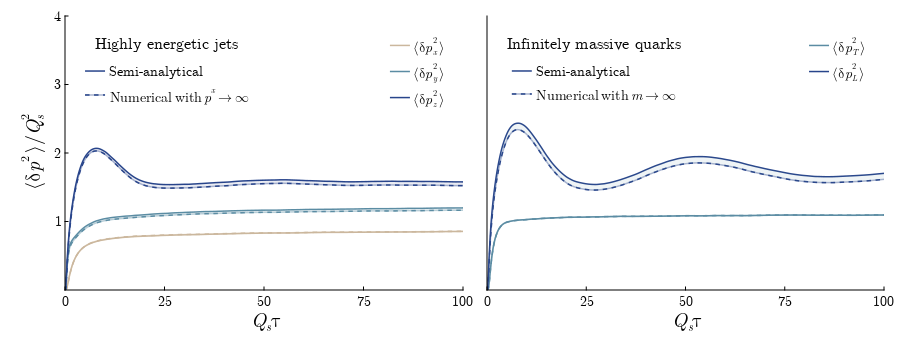

In [3]:
using CairoMakie
using ColorSchemes
using Interpolations

segmented_cmap = cgrad(:lapaz, 11, categorical = true)
colors = [segmented_cmap[9], segmented_cmap[6], segmented_cmap[3]]
# segmented_cmap = cgrad(:starrynight, 11, categorical = true)
# colors = [segmented_cmap[11], segmented_cmap[4], segmented_cmap[1]]

fig = Figure(resolution = (900, 350), font = "CMU Serif")
axes = [Axis(fig[1, i], 
        xlabel=L"Q_s\tau", ylabel=L"\langle\delta p^2\,\rangle/Q_s^2",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = false, ygridvisible = false) for i in 1:2]

# jets
components = ['x', 'y', 'z']
for i in 1:3
        string_as_varname("qhat_"*components[i], lines!(axes[1], tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs^2, linewidth = 1.5, color=colors[i], linestyle=:dash))
        lines!(axes[1], tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs^2, linewidth = 1.5, color=(colors[i], 0.4))
        string_as_varname("wong_jets_"*components[i], lines!(axes[1], tau_wong_jets*Qs/hbarc, mom_broad_wong_jets[:, i]/Qs^2, linewidth = 1.5, color=colors[i]))
        interp_wong_jets = LinearInterpolation(tau_wong_jets*Qs/hbarc,  mom_broad_wong_jets[:, i]/Qs^2)
        band!(axes[1], tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs^2, interp_wong_jets(tau_qhat*Qs/hbarc), color=(colors[i], 0.1))
end

numerical = [LineElement(color = colors[3], linestyle = "-", linewidth = 1.5), LineElement(color = (colors[3], 0.4), linewidth = 1.5)]

legend_wong_jets = [L"\langle\delta p^2_x\,\rangle", L"\langle\delta p^2_y\,\rangle", L"\langle\delta p^2_z\,\rangle"]
axislegend(axes[1], [wong_jets_x, wong_jets_y, wong_jets_z], legend_wong_jets, labelsize=14, position = :rt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_wong_qhat = ["Semi-analytical", L"\mathrm{Numerical\,with\,}p^x\rightarrow\infty"]
axislegend(axes[1], [wong_jets_z, numerical], legend_wong_qhat, "Highly energetic jets", titlesize = 16, labelsize=14, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

# heavy quarks
string_as_varname("kappa_T", lines!(axes[2], tau_kappa*Qs/hbarc, (mom_broad_kappa[:, 1]+mom_broad_kappa[:, 2])/Qs^2, linewidth = 1.5, color=colors[2], linestyle=:dash))
lines!(axes[2], tau_kappa*Qs/hbarc, (mom_broad_kappa[:, 1]+mom_broad_kappa[:, 2])/Qs^2, linewidth = 1.5, color=(colors[2], 0.4))
string_as_varname("wong_hqs_T", lines!(axes[2], tau_wong_hqs*Qs/hbarc, (mom_broad_wong_hqs[:, 1]+mom_broad_wong_hqs[:, 2])/Qs^2, linewidth = 1.5, color=colors[2]))

string_as_varname("kappa_L", lines!(axes[2], tau_kappa*Qs/hbarc, mom_broad_kappa[:, 3]/Qs^2, linewidth = 1.5, color=colors[3], linestyle=:dash))
lines!(axes[2], tau_kappa*Qs/hbarc, mom_broad_kappa[:, 3]/Qs^2, linewidth = 1.5, color=(colors[3], 0.4))
string_as_varname("wong_hqs_L", lines!(axes[2], tau_wong_hqs*Qs/hbarc, mom_broad_wong_hqs[:, 3]/Qs^2, linewidth = 1.5, color=colors[3]))
interp_wong_hqs = LinearInterpolation(tau_wong_hqs*Qs/hbarc, mom_broad_wong_hqs[:, 3]/Qs^2)
band!(axes[2], tau_kappa*Qs/hbarc, mom_broad_kappa[:, 3]/Qs^2, interp_wong_hqs(tau_kappa*Qs/hbarc), color=(colors[2], 0.1))

legend_wong_hqs = [L"\langle\delta p^2_T\,\rangle", L"\langle\delta p^2_L\,\rangle"]
axislegend(axes[2], [wong_hqs_T, wong_hqs_L], legend_wong_hqs, labelsize=14, position = :rt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_wong_kappa = ["Semi-analytical", L"\mathrm{Numerical\,with\,}m\rightarrow\infty"]
axislegend(axes[2], [wong_hqs_L, numerical], legend_wong_kappa, "Infinitely massive quarks", titlesize = 16, labelsize=14, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

linkaxes!(axes[1], axes[2])
hideydecorations!(axes[2], grid = false)

ylims!(axes[1], 0, 4)
xlims!(axes[1], 0, 100)
for i in 1:2
        axes[i].xticks = ([0, 25, 50, 75, 100], ["0", "25", "50", "75", "100"])
        axes[i].yticks = ([1, 2, 3, 4], ["1", "2", "3", "4"])
end

display(fig)
# save("makie_wong_kappa_qhat.png", fig, px_per_unit = 5.0) 

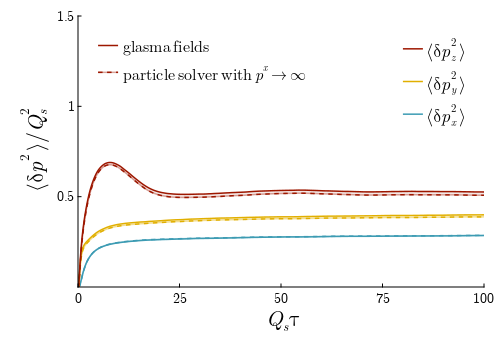

In [3]:
using CairoMakie
using ColorSchemes
using Interpolations

wesanderson = ["#3c9bb3", "#78b7c5", "#ebcc2a", "#e1af00", "#9d1700"]
colors = [wesanderson[1], wesanderson[4], wesanderson[5]]

fig = Figure(resolution = (500, 350), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        # xlabel=L"Q_s\tau", ylabel=L"\langle\delta p^2_{x,y,z}\,\rangle/Q_s^2",
        xlabel=L"Q_s\tau", ylabel=L"\langle\delta p^2\,\rangle/Q_s^2",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = false, ygridvisible = false)

# dimenstion of fundamental representation for SU(3)
DR = 3

# jets
components = ['z', 'y', 'x']
for i in 1:3
        string_as_varname("qhat_"*components[i], lines!(axes, tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs^2/DR, linewidth = 1.5, color=colors[i], linestyle=:dash))
        lines!(axes, tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs^2/DR, linewidth = 1.5, color=(colors[i], 0.4))
        string_as_varname("wong_jets_"*components[i], lines!(axes, tau_wong_jets*Qs/hbarc, mom_broad_wong_jets[:, i]/Qs^2/DR, linewidth = 1.5, color=colors[i]))
        interp_wong_jets = LinearInterpolation(tau_wong_jets*Qs/hbarc,  mom_broad_wong_jets[:, i]/Qs^2/DR)
        band!(axes, tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs^2/DR, interp_wong_jets(tau_qhat*Qs/hbarc), color=(colors[i], 0.1))
end

numerical = [LineElement(color = colors[3], linestyle = "-", linewidth = 1.5), LineElement(color = (colors[3], 0.4), linewidth = 1.5)]

legend_wong_jets = [L"\langle\delta p^2_z\,\rangle", L"\langle\delta p^2_y\,\rangle", L"\langle\delta p^2_x\,\rangle"]
axislegend(axes, [wong_jets_x, wong_jets_y, wong_jets_z], legend_wong_jets, labelsize=18, position = :rt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_wong_qhat = [L"\mathrm{glasma\,fields}", L"\mathrm{particle\,solver\,with\,}p^x\rightarrow\infty"]
axislegend(axes, [wong_jets_x, numerical], legend_wong_qhat, titlesize = 16, labelsize=16, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))
# axislegend(axes, [wong_jets_x, numerical], legend_wong_qhat, L"\mathrm{Highly\,energetic\,jets}", titlesize = 16, labelsize=14, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))
# text!(axes, L"\mathrm{Highly\,energetic\,jets}", position = (13, 8/3+0.1), textsize=14)

ylims!(axes, 0, 1.5)
xlims!(axes, 0, 100)
axes.xticks = ([0, 25, 50, 75, 100], ["0", "25", "50", "75", "100"])
axes.yticks = ([0.5, 1, 1.5], ["0.5", "1", "1.5"])

display(fig)
# save("final_wong_qhat.png", fig, px_per_unit = 5.0) 

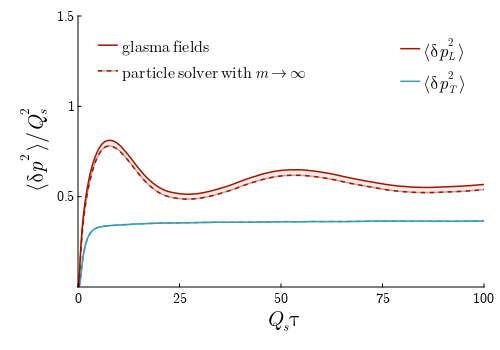

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000b280d70, 2500.0, 1750.0)


In [4]:
using CairoMakie
using ColorSchemes
using Interpolations

wesanderson = ["#3c9bb3", "#78b7c5", "#ebcc2a", "#e1af00", "#9d1700"]
colors = [wesanderson[1], wesanderson[4], wesanderson[5]]

fig = Figure(resolution = (500, 350), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        # xlabel=L"Q_s\tau", ylabel=L"\langle\delta p^2_{L.T}\,\rangle/Q_s^2",
        xlabel=L"Q_s\tau", ylabel=L"\langle\delta p^2\,\rangle/Q_s^2",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = false, ygridvisible = false)

# dimenstion of fundamental representation for SU(3)
DR = 3
# heavy quarks
string_as_varname("kappa_T", lines!(axes, tau_kappa*Qs/hbarc, (mom_broad_kappa[:, 1]+mom_broad_kappa[:, 2])/Qs^2/DR, linewidth = 1.5, color=colors[1], linestyle=:dash))
lines!(axes, tau_kappa*Qs/hbarc, (mom_broad_kappa[:, 1]+mom_broad_kappa[:, 2])/Qs^2/DR, linewidth = 1.5, color=(colors[1], 0.4))
string_as_varname("wong_hqs_T", lines!(axes, tau_wong_hqs*Qs/hbarc, (mom_broad_wong_hqs[:, 1]+mom_broad_wong_hqs[:, 2])/Qs^2/DR, linewidth = 1.5, color=colors[1]))

string_as_varname("kappa_L", lines!(axes, tau_kappa*Qs/hbarc, mom_broad_kappa[:, 3]/Qs^2/DR, linewidth = 1.5, color=colors[3], linestyle=:dash))
lines!(axes, tau_kappa*Qs/hbarc, mom_broad_kappa[:, 3]/Qs^2/DR, linewidth = 1.5, color=(colors[3], 0.4))
string_as_varname("wong_hqs_L", lines!(axes, tau_wong_hqs*Qs/hbarc, mom_broad_wong_hqs[:, 3]/Qs^2/DR, linewidth = 1.5, color=colors[3]))
interp_wong_hqs = LinearInterpolation(tau_wong_hqs*Qs/hbarc, mom_broad_wong_hqs[:, 3]/Qs^2/DR)
band!(axes, tau_kappa*Qs/hbarc, mom_broad_kappa[:, 3]/Qs^2/DR, interp_wong_hqs(tau_kappa*Qs/hbarc), color=(colors[3], 0.1))

legend_wong_hqs = [L"\langle\delta p^2_L\,\rangle", L"\langle\delta p^2_T\,\rangle"]
axislegend(axes, [wong_hqs_L, wong_hqs_T], legend_wong_hqs, labelsize=18, position = :rt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_wong_kappa = [L"\mathrm{glasma\,fields}", L"\mathrm{particle\,solver\,with\,}m\rightarrow\infty"]
# axislegend(axes, [wong_hqs_L, numerical], legend_wong_kappa, L"\mathrm{Infinitely\,massive\,quarks}", titlesize = 16, labelsize=14, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))
axislegend(axes, [wong_hqs_L, numerical], legend_wong_kappa, titlesize = 16, labelsize=16, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

ylims!(axes, 0, 1.5)
xlims!(axes, 0, 100)
axes.xticks = ([0, 25, 50, 75, 100], ["0", "25", "50", "75", "100"])
axes.yticks = ([0.5, 1, 1.5], ["0.5", "1", "1.5"])

display(fig)
save("final_wong_kappa.png", fig, px_per_unit = 5.0) 

---
### Plots for article

In [13]:
custom_colors = ["#9300d3", "#019d73", "#57b5e8"]


3-element Vector{String}:
 "#9300d3"
 "#019d73"
 "#57b5e8"

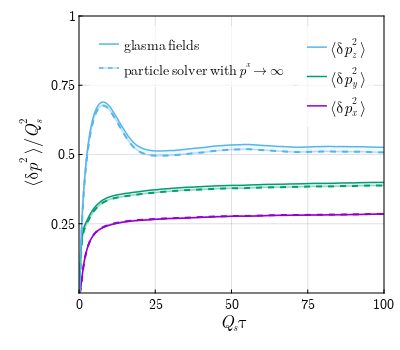

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000000a9c6f50, 300.0, 262.0, IOContext(IOStream(<file /home/dana/curraun/notebooks/wong_qhat_final.pdf>)))


In [26]:
using CairoMakie
using ColorSchemes
using Interpolations

colors = [custom_colors[1], custom_colors[2], custom_colors[3]]
width_line = 1.5

fig = Figure(resolution = (400, 350), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        # xlabel=L"Q_s\tau", ylabel=L"\langle\delta p^2_{x,y,z}\,\rangle/Q_s^2",
        xlabel=L"Q_s\tau", ylabel=L"\langle\delta p^2\,\rangle/Q_s^2",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = true, ygridvisible = true)

# dimenstion of fundamental representation for SU(3)
DR = 3

# jets
components = ['z', 'y', 'x']
for i in 1:3
        string_as_varname("qhat_"*components[i], lines!(axes, tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs^2/DR, linewidth = 2, color=colors[i], linestyle=:dash))
        lines!(axes, tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs^2/DR, linewidth = width_line, color=(colors[i], 0.4))
        string_as_varname("wong_jets_"*components[i], lines!(axes, tau_wong_jets*Qs/hbarc, mom_broad_wong_jets[:, i]/Qs^2/DR, linewidth = width_line, color=colors[i]))
        interp_wong_jets = LinearInterpolation(tau_wong_jets*Qs/hbarc,  mom_broad_wong_jets[:, i]/Qs^2/DR)
        band!(axes, tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs^2/DR, interp_wong_jets(tau_qhat*Qs/hbarc), color=(colors[i], 0.1))
end

numerical = [LineElement(color = colors[3], linestyle = "-", linewidth = width_line), LineElement(color = (colors[3], 0.4), linewidth = width_line)]

legend_wong_jets = [L"\langle\delta p^2_z\,\rangle", L"\langle\delta p^2_y\,\rangle", L"\langle\delta p^2_x\,\rangle"]
axislegend(axes, [wong_jets_x, wong_jets_y, wong_jets_z], legend_wong_jets, labelsize=16, position = :rt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_wong_qhat = [L"\mathrm{glasma\,fields}", L"\mathrm{particle\,solver\,with\,}p^x\rightarrow\infty"]
axislegend(axes, [wong_jets_x, numerical], legend_wong_qhat, labelsize=14, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))
# axislegend(axes, [wong_jets_x, numerical], legend_wong_qhat, L"\mathrm{Highly\,energetic\,jets}", titlesize = 16, labelsize=14, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))
# text!(axes, L"\mathrm{Highly\,energetic\,jets}", position = (13, 8/3+0.1), textsize=14)

ylims!(axes, 0, 1)
xlims!(axes, 0, 100)
axes.xticks = ([0, 25, 50, 75, 100], ["0", "25", "50", "75", "100"])
axes.yticks = ([0.25, 0.5, 0.75, 1], ["0.25", "0.5", "0.75", "1"])

display(fig)
save("wong_qhat_final.pdf", fig) 

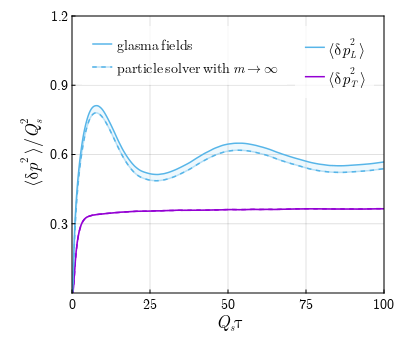

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000000931cb50, 300.0, 262.0, IOContext(IOStream(<file /home/dana/curraun/notebooks/wong_kappa_final.pdf>)))


In [27]:
fig = Figure(resolution = (400, 350), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        # xlabel=L"Q_s\tau", ylabel=L"\langle\delta p^2_{L.T}\,\rangle/Q_s^2",
        xlabel=L"Q_s\tau", ylabel=L"\langle\delta p^2\,\rangle/Q_s^2",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5)

# dimenstion of fundamental representation for SU(3)
DR = 3
# heavy quarks
string_as_varname("kappa_T", lines!(axes, tau_kappa*Qs/hbarc, (mom_broad_kappa[:, 1]+mom_broad_kappa[:, 2])/Qs^2/DR, linewidth = width_line, color=colors[1], linestyle=:dash))
lines!(axes, tau_kappa*Qs/hbarc, (mom_broad_kappa[:, 1]+mom_broad_kappa[:, 2])/Qs^2/DR, linewidth = width_line, color=(colors[1], 0.4))
string_as_varname("wong_hqs_T", lines!(axes, tau_wong_hqs*Qs/hbarc, (mom_broad_wong_hqs[:, 1]+mom_broad_wong_hqs[:, 2])/Qs^2/DR, linewidth = width_line, color=colors[1]))

string_as_varname("kappa_L", lines!(axes, tau_kappa*Qs/hbarc, mom_broad_kappa[:, 3]/Qs^2/DR, linewidth = width_line, color=colors[3], linestyle=:dash))
lines!(axes, tau_kappa*Qs/hbarc, mom_broad_kappa[:, 3]/Qs^2/DR, linewidth = width_line, color=(colors[3], 0.4))
string_as_varname("wong_hqs_L", lines!(axes, tau_wong_hqs*Qs/hbarc, mom_broad_wong_hqs[:, 3]/Qs^2/DR, linewidth = width_line, color=colors[3]))
interp_wong_hqs = LinearInterpolation(tau_wong_hqs*Qs/hbarc, mom_broad_wong_hqs[:, 3]/Qs^2/DR)
band!(axes, tau_kappa*Qs/hbarc, mom_broad_kappa[:, 3]/Qs^2/DR, interp_wong_hqs(tau_kappa*Qs/hbarc), color=(colors[3], 0.1))

legend_wong_hqs = [L"\langle\delta p^2_L\,\rangle", L"\langle\delta p^2_T\,\rangle"]
axislegend(axes, [wong_hqs_L, wong_hqs_T], legend_wong_hqs, labelsize=16, position = :rt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_wong_kappa = [L"\mathrm{glasma\,fields}", L"\mathrm{particle\,solver\,with\,}m\rightarrow\infty"]
# axislegend(axes, [wong_hqs_L, numerical], legend_wong_kappa, L"\mathrm{Infinitely\,massive\,quarks}", titlesize = 16, labelsize=14, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))
axislegend(axes, [wong_hqs_L, numerical], legend_wong_kappa, labelsize=14, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

ylims!(axes, 0, 1.2)
xlims!(axes, 0, 100)
axes.xticks = ([0, 25, 50, 75, 100], ["0", "25", "50", "75", "100"])
axes.yticks = ([0.3, 0.6, 0.9, 1.2], ["0.3", "0.6", "0.9", "1.2"])

display(fig)
save("wong_kappa_final.pdf", fig) 